# Pipeline for MAR column

Enable auto-reloading of external modules

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

Import dependencies

In [12]:
from matplotlib import rcParams
from sys import getsizeof
from pprint import pprint

from utils.data_loader import *
from utils.null_handler import *
from utils.EDA_utils import *
from utils.simple_utils import *
from utils.model_tuning_utils import *
from config import *

import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100

In [3]:
try:
    from folktables import ACSDataSource, ACSEmployment
except:
    !pip install folktables
    from folktables import ACSDataSource, ACSEmployment

## Loading ACSEmployment data

In [4]:
config = {
    'state': ["NY"],
    'year': '2018',
    'task': ACSEmployment
}
TARGET_COLUMN = 'MAR'
COLUMN_TYPE = get_column_type(TARGET_COLUMN)

In [5]:
X_data_load, y_data = ACSDataLoader(task=config['task'], state=config['state'], year=config['year'])

In [6]:
# If the task is ACSEmployment, we can optimize the file size
print(f'Original: {int(getsizeof(X_data_load) / 1024**2)} mb')
print(f'Optimized: {int(getsizeof(optimize_ACSEmployment(X_data_load)) / 1024**2)} mb')

X_data = optimize_ACSEmployment(X_data_load)

Original: 24 mb
Optimized: 12 mb


In [7]:
missing = ['SCHL', 'ESP', 'MIG', 'MIL', 'DREM']
X_data = initially_handle_nulls(X_data, missing)
# Rechecking if there are nulls -- if the null_handler has run correctly, there should not be
X_data.isnull().sum()

Dataset shape before handling nulls:  (196967, 16)
Impute values:  {'SCHL': 0, 'ESP': 0, 'MIG': 0, 'MIL': 0, 'DREM': 0}
Dataset shape after handling nulls:  (196967, 16)


AGEP        0
SCHL        0
MAR         0
RELP        0
DIS         0
ESP         0
CIT         0
MIG         0
MIL         0
ANC         0
NATIVITY    0
DEAR        0
DEYE        0
DREM        0
SEX         0
RAC1P       0
dtype: int64

## Tune hyper-parameters and find the best model

### Find the best model for a baseline dataset (no nulls)

baseline_X_train shape:  (157573, 16)
baseline_X_test shape:  (39394, 16)
Tuning for LogisticRegression is finished
####################  Folktables [NY 2018]  ####################
Test model:  LogisticRegression
Test model parameters:
{'max_iter': 50, 'penalty': 'none', 'solver': 'lbfgs'}

              precision    recall  f1-score   support

           0      0.832     0.722     0.773     21095
           1      0.722     0.832     0.773     18299

    accuracy                          0.773     39394
   macro avg      0.777     0.777     0.773     39394
weighted avg      0.781     0.773     0.773     39394



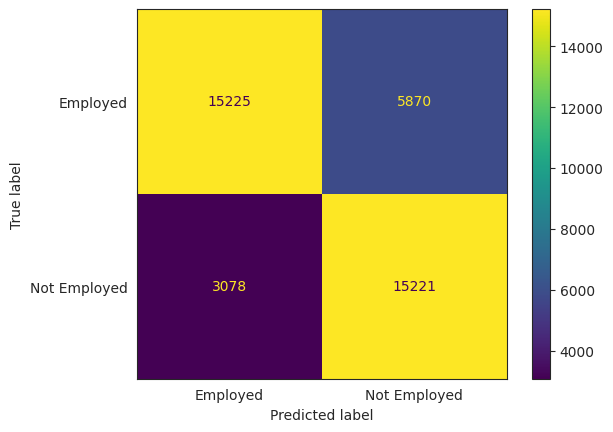

Tuning for DecisionTreeClassifier is finished
####################  Folktables [NY 2018]  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.6}

              precision    recall  f1-score   support

           0      0.869     0.788     0.826     21095
           1      0.779     0.863     0.819     18299

    accuracy                          0.822     39394
   macro avg      0.824     0.825     0.822     39394
weighted avg      0.827     0.822     0.823     39394



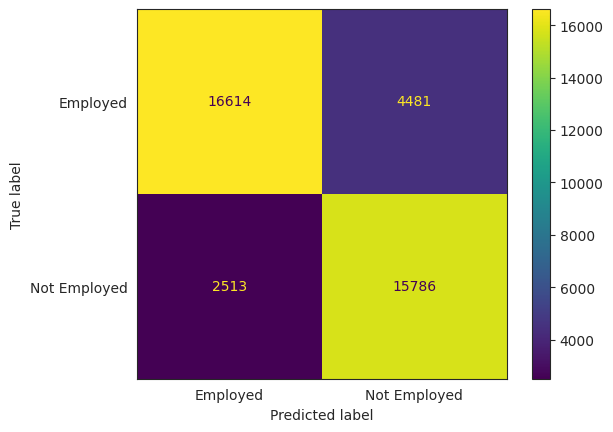

Tuning for XGBClassifier is finished
####################  Folktables [NY 2018]  ####################
Test model:  XGBClassifier
Test model parameters:
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

           0      0.866     0.805     0.834     21095
           1      0.792     0.856     0.823     18299

    accuracy                          0.829     39394
   macro avg      0.829     0.831     0.829     39394
weighted avg      0.832     0.829     0.829     39394



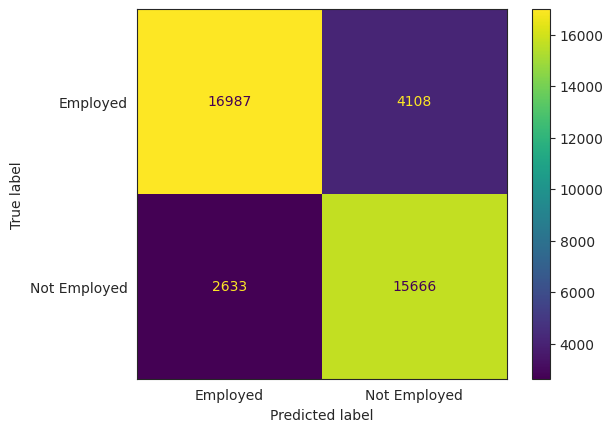

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Folktables [NY 2018],LogisticRegression,0.772859,0.772859,"{'max_iter': 50, 'penalty': 'none', 'solver': ..."
1,Folktables [NY 2018],DecisionTreeClassifier,0.822382,0.822460,"{'criterion': 'entropy', 'max_depth': 10, 'max..."
2,Folktables [NY 2018],XGBClassifier,0.828690,0.828883,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


In [8]:
# Copy datasets for tuning to avoid confusion with datasets for imputations
baseline_X_data, baseline_y_data = X_data.copy(deep=True), y_data.copy(deep=True)

ML_baseline_results_df = test_baseline_models(baseline_X_data, baseline_y_data)
ML_baseline_results_df

In [9]:
for index, row in ML_baseline_results_df.iterrows():
    print(f'\n\nModel name: {row["Model_Name"]}')
    pprint(row['Model_Best_Params'])



Model name: LogisticRegression
{'max_iter': 50, 'penalty': 'none', 'solver': 'lbfgs'}


Model name: DecisionTreeClassifier
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.6}


Model name: XGBClassifier
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 200,
 'objective': 'binary:logistic'}


### Find the best model for a drop-column dataset (with nulls)

baseline_X_train shape:  (157573, 15)
baseline_X_test shape:  (39394, 15)
Tuning for LogisticRegression is finished
####################  Folktables [NY 2018]  ####################
Test model:  LogisticRegression
Test model parameters:
{'max_iter': 50, 'penalty': 'none', 'solver': 'sag'}

              precision    recall  f1-score   support

           0      0.832     0.721     0.772     21095
           1      0.721     0.832     0.773     18299

    accuracy                          0.772     39394
   macro avg      0.776     0.776     0.772     39394
weighted avg      0.780     0.772     0.772     39394



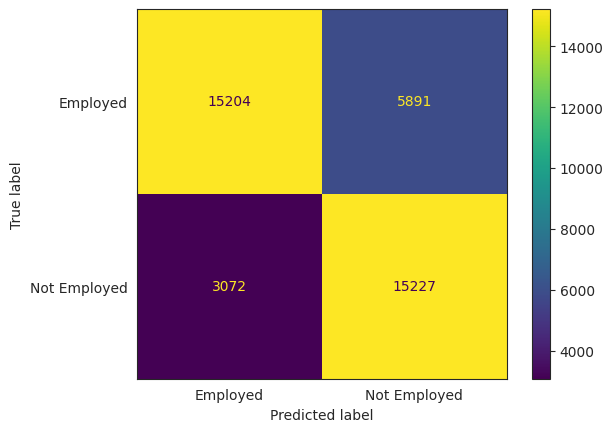

Tuning for DecisionTreeClassifier is finished
####################  Folktables [NY 2018]  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'gini', 'max_depth': 10, 'max_features': 0.6}

              precision    recall  f1-score   support

           0      0.873     0.781     0.824     21095
           1      0.775     0.869     0.819     18299

    accuracy                          0.822     39394
   macro avg      0.824     0.825     0.822     39394
weighted avg      0.827     0.822     0.822     39394



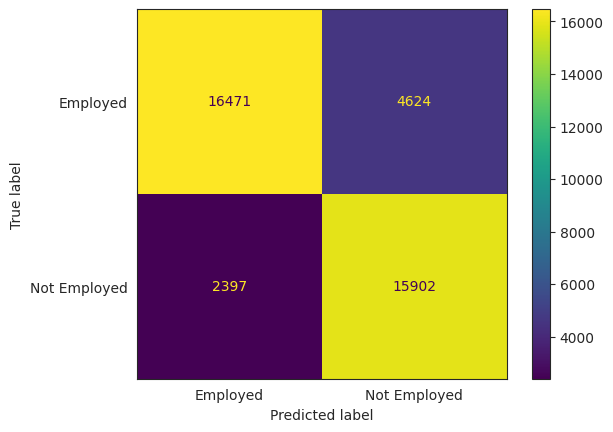

Tuning for XGBClassifier is finished
####################  Folktables [NY 2018]  ####################
Test model:  XGBClassifier
Test model parameters:
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 300,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

           0      0.867     0.804     0.834     21095
           1      0.791     0.858     0.823     18299

    accuracy                          0.829     39394
   macro avg      0.829     0.831     0.829     39394
weighted avg      0.832     0.829     0.829     39394



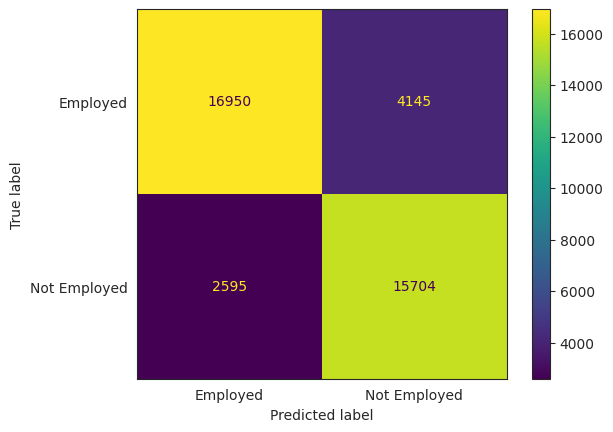

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Folktables [NY 2018],LogisticRegression,0.772478,0.772478,"{'max_iter': 50, 'penalty': 'none', 'solver': ..."
1,Folktables [NY 2018],DecisionTreeClassifier,0.821738,0.821775,"{'criterion': 'gini', 'max_depth': 10, 'max_fe..."
2,Folktables [NY 2018],XGBClassifier,0.828737,0.828908,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


In [10]:
baseline_X_data.drop(columns=[TARGET_COLUMN], axis=1, inplace=True)

ML_drop_column_results_df = test_baseline_models(baseline_X_data, baseline_y_data)
ML_drop_column_results_df

In [11]:
for index, row in ML_drop_column_results_df.iterrows():
    print(f'\n\nModel name: {row["Model_Name"]}')
    pprint(row['Model_Best_Params'])



Model name: LogisticRegression
{'max_iter': 50, 'penalty': 'none', 'solver': 'sag'}


Model name: DecisionTreeClassifier
{'criterion': 'gini', 'max_depth': 10, 'max_features': 0.6}


Model name: XGBClassifier
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 300,
 'objective': 'binary:logistic'}


## Simulate Null Scenarios

In [78]:
corrupted_data = simulate_scenario(X_data, SIMULATED_SCENARIOS_DICT[TARGET_COLUMN])

## Impute Nulls

Check correctness of conditional techniques

In [80]:
mapping_dict = check_conditional_techniques(corrupted_data, TARGET_COLUMN)
pprint(mapping_dict)

{'RAC1P': {'RAC1P-1': (60781, 'MAR-1.0'),
           'RAC1P-2': (13861, 'MAR-5.0'),
           'RAC1P-3': (271, 'MAR-5.0'),
           'RAC1P-4': (3, 'MAR-1.0'),
           'RAC1P-5': (143, 'MAR-5.0'),
           'RAC1P-6': (8429, 'MAR-1.0'),
           'RAC1P-7': (42, 'MAR-5.0'),
           'RAC1P-8': (6255, 'MAR-5.0'),
           'RAC1P-9': (3749, 'MAR-5.0')},
 'SEX': {'SEX-1': (45357, 'MAR-5.0'), 'SEX-2': (42692, 'MAR-5.0')}}


Print plots for analysis





 ###############  Impute MAR column with drop-column technique  ###############




 ###############  Impute MAR column with drop-rows technique  ###############
Number of nulls in MAR column in the corrupted dataframe:  8603
Number of nulls in MAR column in the imputed dataframe:  0


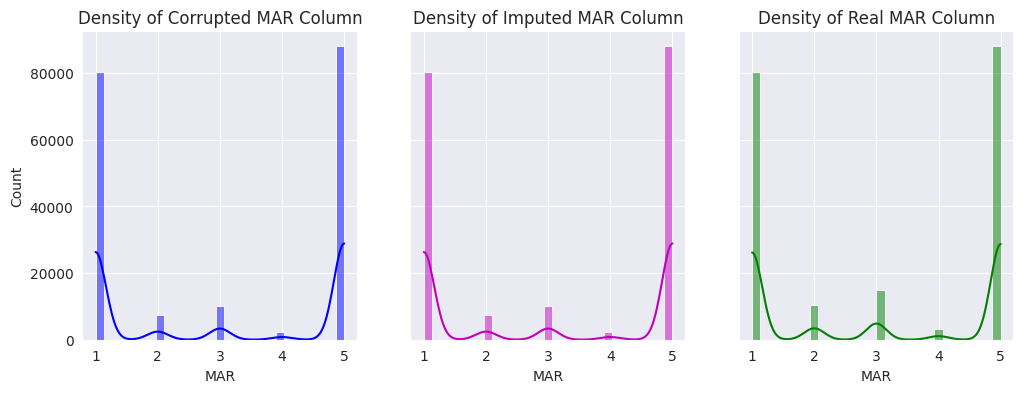





 ###############  Impute MAR column with predict-by-sklearn technique  ###############
Number of nulls in MAR column in the corrupted dataframe:  8603
Number of nulls in MAR column in the imputed dataframe:  0


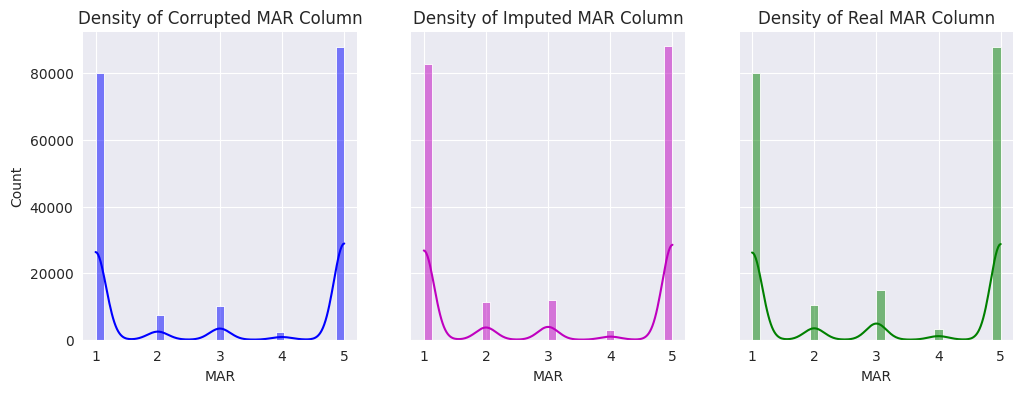





 ###############  Impute MAR column with impute-by-mode technique  ###############
Impute values:  {'MAR': 5.0}
Number of nulls in MAR column in the corrupted dataframe:  8603
Number of nulls in MAR column in the imputed dataframe:  0


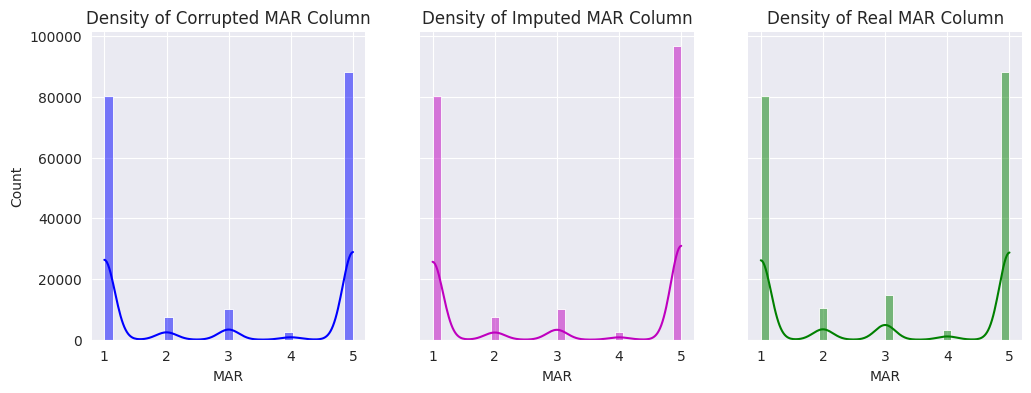





 ###############  Impute MAR column with impute-by-mode-trimmed technique  ###############
Impute values:  {'MAR': 5.0}
Number of nulls in MAR column in the corrupted dataframe:  8603
Number of nulls in MAR column in the imputed dataframe:  0


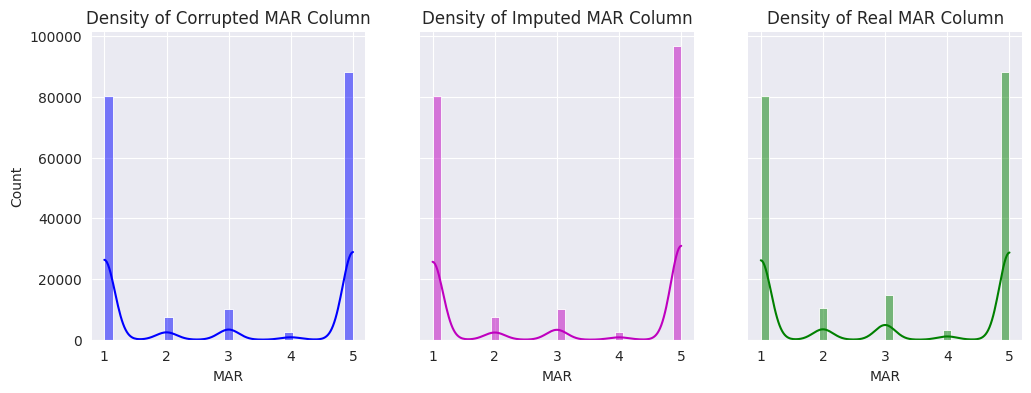





 ###############  Impute MAR column with impute-by-mode-conditional technique  ###############
Impute MAR with value 5.0, where SEX == 2
Impute MAR with value 5.0, where SEX == 1
Number of nulls in MAR column in the corrupted dataframe:  8603
Number of nulls in MAR column in the imputed dataframe:  0


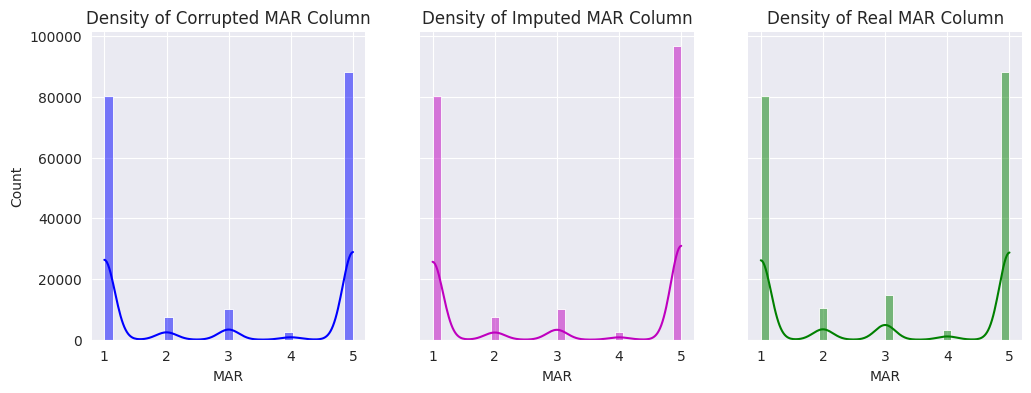

Impute MAR with value 1.0, where RAC1P == 1
Impute MAR with value 5.0, where RAC1P == 2
Impute MAR with value 1.0, where RAC1P == 6
Impute MAR with value 5.0, where RAC1P == 8
Impute MAR with value 5.0, where RAC1P == 9
Impute MAR with value 5.0, where RAC1P == 3
Impute MAR with value 5.0, where RAC1P == 5
Impute MAR with value 5.0, where RAC1P == 7
Impute MAR with value 1.0, where RAC1P == 4
Number of nulls in MAR column in the corrupted dataframe:  8603
Number of nulls in MAR column in the imputed dataframe:  0


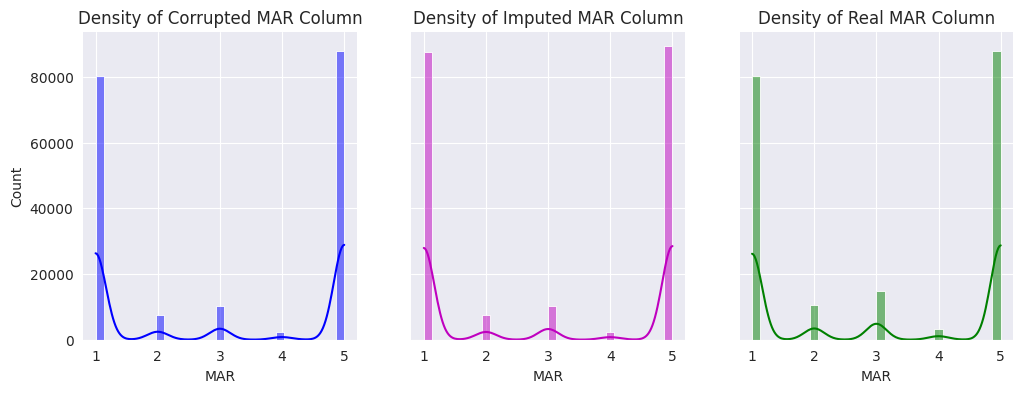

In [81]:
imputed_data_dict = impute_df_with_all_techniques(X_data, corrupted_data, TARGET_COLUMN, COLUMN_TYPE)